#### Goal :: Predict the sale (number of items) for the shop-item pair in the  test set. The test set is for one month - November 2015 

In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline

#### Read data

In [2]:
DATA_FOLDER = './'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [3]:
print("Total Items: {}".format(items.item_id.nunique()))
print("Total Categories: {}".format(item_categories.item_category_id.nunique()))
print("Total Shops: {}".format(shops.shop_id.nunique()))
print("\n--------------------------------------------------------\n")

print("Training data")
print("  # unique shops: {}".format(transactions.shop_id.nunique()))
print("  # unique items: {}".format(transactions.item_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Test data")
print("  # unique shops: {}".format(test.shop_id.nunique()))
print("  # unique items: {}".format(test.item_id.nunique()))

Total Items: 22170
Total Categories: 84
Total Shops: 60

--------------------------------------------------------

Training data
  # unique shops: 60
  # unique items: 21807

--------------------------------------------------------

Test data
  # unique shops: 42
  # unique items: 5100


there are some combinations in test data which are not there in training data

Get rid of rows with -ve item price.

Add the category_id column to the transaction and test df

In [4]:
print("Number of objects with item_price lt zero: {}".format(len(transactions[transactions.item_price < 0])))

# Drop the rows with price lt zero. ther is only one.
transactions = transactions[transactions.item_price > 0]

# Merging to get category_id in the transaction and test df
transactions = pd.merge(transactions, items[['item_id', 'item_category_id']], on='item_id', how='inner')
test_mod = pd.merge(test, items[['item_id', 'item_category_id']], on='item_id', how='inner')

Number of objects with item_price lt zero: 1


###### Items for which price remains constant

In [5]:
# Number of items for which prices remain constant throughout
num_const_price_items = sum(transactions.groupby('item_id').item_price.nunique() == 1)
print("# Items for which price remains constant: {}".format(num_const_price_items))

# Items for which prices remain constant throughout
const_price_items = np.where(transactions.groupby('item_id').item_price.nunique() == 1)[0]

# Items for which price remains constant: 5926


In [6]:
i_id = transactions[transactions.item_id.isin(const_price_items)].groupby(["item_id"]).item_cnt_day.sum().argmax()

print("Item# {0}has a constant price and sells the most\n".format(i_id))
iname = str(items[items.item_id == i_id][["item_name"]])
print(iname)

Item# 20949has a constant price and sells the most

                                               item_name
20949  Фирменный пакет майка 1С Интерес белый (34*42)...


In [7]:
print("const_price_items belong to {} different categories".format(items[items.item_id.isin(const_price_items)].item_category_id.nunique()))

const_price_items belong to 72 different categories


In [8]:
test_mod.head(3)

,ID,shop_id,item_id,item_category_id
0,0,5,5037,19
1,5100,4,5037,19
2,10200,6,5037,19


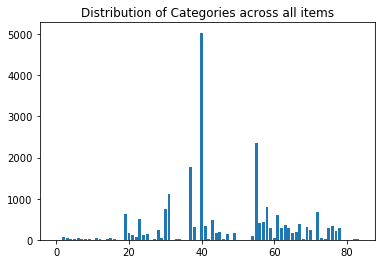

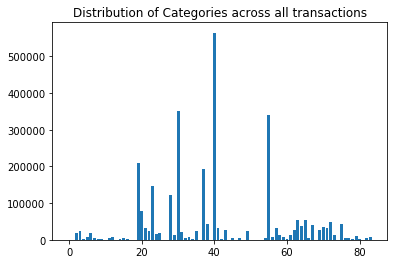

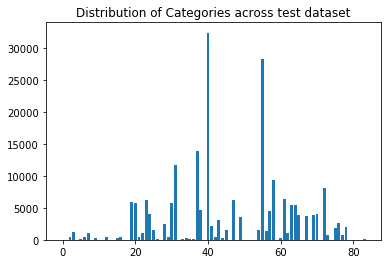

In [9]:
%matplotlib inline

unique_categories, count = np.unique(items.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories, count)    
plt.title( "Distribution of Categories across all items")
plt.show()

unique_categories_trans, count_trans = np.unique(transactions.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories_trans, count_trans)
plt.title("Distribution of Categories across all transactions")
plt.show()

unique_categories_test, count_test = np.unique(test_mod.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories_test, count_test)
plt.title("Distribution of Categories across test dataset")
plt.show()

In [54]:
categ_distr = transactions.groupby(['item_category_id']).size().reset_index(name='num')


In [57]:
df = categ_distr.sort("num", ascending=[0])[6:]


/Users/pkaul2/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


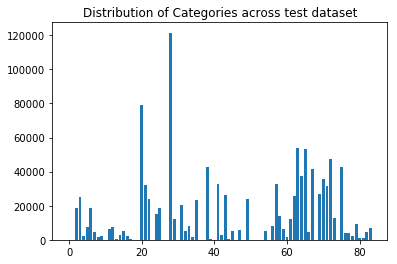

In [60]:
ax1 = plt.subplot()
ax1.bar(list(df.item_category_id), list(df.num))
plt.title("Distribution of Categories across test dataset")
plt.show()

Looks more or less the same

In [175]:
items_test_nottrans = len(set(test.item_id.unique()) - set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
intersection_items_test_transac = len(set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
item_count_test = len(set(test.item_id.unique()))

print("# items in test set: {}".format(item_count_test))
print("# items in test set and transaction set: {}".format(intersection_items_test_transac))
print("# items in test but not transaction: {}".format(items_test_nottrans))

print("\n")

shops_test_nottrans = len(set(test.shop_id.unique()) - set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
intersection_shops_test_transac = len(set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
shop_count_test = len(set(test.shop_id.unique()))

print("# shops in test set: {}".format(shop_count_test))
print("# shops in test set and transaction set: {}".format(intersection_shops_test_transac))
print("# shops in test but not transaction: {}".format(shops_test_nottrans))

# items in test set: 5100
# items in test set and transaction set: 4737
# items in test but not transaction: 363


# shops in test set: 42
# shops in test set and transaction set: 42
# shops in test but not transaction: 0


There are some items in test set which do not exist in transaction dataset. 
However, these items will probabaly be similar to some other items in the transaction dataset.
We can use this simillarity to predict for these items

###### Constructing previous_value_benchmark

For the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

In [187]:
def get_item_cnt(shopid, itemid):
    if (shopid, itemid) in trans_oct_grouped:
        count  = trans_oct_grouped[int(shopid), int(itemid)]
        if(count > 20):
            return 20
        elif(count < 0):
            return 0
        else:
            return count
    else:
        return 0

trans_oct = transactions[transactions.date_block_num == 33]
trans_oct_grouped = trans_oct.groupby(["shop_id", "item_id"]).item_cnt_day.sum()
previous_value_benchmark_submission = test

previous_value_benchmark_submission["item_cnt_month"] = previous_value_benchmark_submission.apply(lambda x: get_item_cnt(x.shop_id, x.item_id), axis=1)

In [188]:
previous_value_benchmark_submission.item_cnt_month.describe()

count    214200.000000
mean          0.255649
std           1.089856
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: item_cnt_month, dtype: float64

##### writing previous_value_benchmark_submission ---> csv file

In [ ]:
previous_value_benchmark_submission[["ID", "item_cnt_month"]].to_csv("previous_value_benchmark_submission", index=False)

###### Distribution of items across months
Get the items which are common to test and transaction data.
For each item:
    How many months have at least one entry for that item?
    

In [137]:
# Items present in both test and transaction data
s = set(test.item_id.unique()).intersection(set(transactions.item_id.unique()))
print(len(s))

4737


In [109]:
item_distr = transactions.groupby(['item_id'])['date_block_num'].unique().reset_index(name='list_months')
item_distr["num_months"] = item_distr.list_months.apply(lambda x: x.size)
item_distr = item_distr.drop(['list_months'], axis=1)
item_distr_testset = item_distr[item_distr.item_id.isin(list(s))]

In [140]:
item_categories.item_category_name

0                      PC - Гарнитуры/Наушники
1                             Аксессуары - PS2
2                             Аксессуары - PS3
3                             Аксессуары - PS4
4                             Аксессуары - PSP
5                          Аксессуары - PSVita
6                        Аксессуары - XBOX 360
7                        Аксессуары - XBOX ONE
8                               Билеты (Цифра)
9                              Доставка товара
10                       Игровые консоли - PS2
11                       Игровые консоли - PS3
12                       Игровые консоли - PS4
13                       Игровые консоли - PSP
14                    Игровые консоли - PSVita
15                  Игровые консоли - XBOX 360
16                  Игровые консоли - XBOX ONE
17                    Игровые консоли - Прочие
18                                  Игры - PS2
19                                  Игры - PS3
20                                  Игры - PS4
21           